# LangGraph with Multi-Agent Workflow

Multiple agents interacting in Workflow design

In [22]:
import os
import json
import operator
import functools
from loguru import logger
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage
)
from langchain.tools import tool
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import FunctionMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_experimental.utilities import PythonREPL
from typing import TypedDict, Annotated, List, Sequence, Literal
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END

In [2]:
# OpenAI API Key solely to use embedding model
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

In [3]:
# Tools to be called by LLM
tools = [TavilySearchResults(max_results=1)]

tool_executor = ToolExecutor(tools) # Can invoke an action??? - Yes, with the right invocation recipe

In [3]:
# Load LLM
llm = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0.1)

In [121]:
# There is no additional kwargs or tool call
llm.invoke("who played against Universitario last night?")

AIMessage(content="I'm sorry, but I can't provide real-time or the most recent updates, including sports results or schedules. To find out who played against Universitario in their most recent match, please check the latest sports news on a reliable website, the official league or team website, or a sports app for the most current information.", response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 16, 'total_tokens': 82}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0aecc077-7ef8-4809-9523-aadeb9cb2405-0')

In [5]:
# Bind tools to llm
llm_bound = llm.bind_tools(tools)

In [54]:
sample_query = HumanMessage(content="who played against Universitario last night?")
sample_call = llm_bound.invoke([sample_query])
sample_call


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L4j3A0mT1AzIxbBuB7rKKsDF', 'function': {'arguments': '{"query":"Universitario match result last night"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 90, 'total_tokens': 114}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ad80cf02-9b21-4536-9595-ad65c23161e8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Universitario match result last night'}, 'id': 'call_L4j3A0mT1AzIxbBuB7rKKsDF'}])

In [10]:
print(sample_call.additional_kwargs)
print(sample_call.additional_kwargs.keys())
sample_call.tool_calls

{'tool_calls': [{'id': 'call_f12XooXziw7ecQ2iY75U7CJF', 'function': {'arguments': '{"query":"Universitario match result last night"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}
dict_keys(['tool_calls'])


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Universitario match result last night'},
  'id': 'call_f12XooXziw7ecQ2iY75U7CJF'}]

In [31]:
# json.loads(last_message.additional_kwargs["function_call"]["arguments"])

print(sample_call.additional_kwargs.keys())
print(sample_call.additional_kwargs["tool_calls"])

# json.loads(sample_call.tool_calls[0]["args"]) # ERROR, single quote string like dict cannot be converted to dict

json.loads(sample_call.additional_kwargs["tool_calls"][0]["function"]["arguments"])



dict_keys(['tool_calls'])
[{'id': 'call_f12XooXziw7ecQ2iY75U7CJF', 'function': {'arguments': '{"query":"Universitario match result last night"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]


{'query': 'Universitario match result last night'}

The tool invocation is the recipe needed to be executed

In [35]:
invocation_sample = ToolInvocation(
        tool=sample_call.additional_kwargs["tool_calls"][0]["function"]["name"],
        tool_input=json.loads(sample_call.additional_kwargs["tool_calls"][0]["function"]["arguments"]),
    )

invocation_sample

ToolInvocation(tool='tavily_search_results_json', tool_input={'query': 'Universitario match result last night'})

The executor (made up of the tools themselves) will execute the recipe (invocation)

In [66]:
invocation_execution = tool_executor.invoke(invocation_sample)
invocation_execution

[{'url': 'https://www.sofascore.com/team/football/universitario/2305',
  'content': 'Universitario previous match was against Comerciantes Unidos in Liga 1, the match ended with result 6 - 0 (Universitario won the match). Universitario fixtures tab is showing the last 100 football matches with statistics and win/draw/lose icons. There are also all Universitario scheduled matches that they are going to play in the future.'}]

In [67]:
str(invocation_execution)

"[{'url': 'https://www.sofascore.com/team/football/universitario/2305', 'content': 'Universitario previous match was against Comerciantes Unidos in Liga 1, the match ended with result 6 - 0 (Universitario won the match). Universitario fixtures tab is showing the last 100 football matches with statistics and win/draw/lose icons. There are also all Universitario scheduled matches that they are going to play in the future.'}]"

In [68]:
print(invocation_sample.tool)
print(FunctionMessage(content=str(invocation_execution), 
                name=invocation_sample.tool)
)

print(llm_bound.invoke(
    [
        FunctionMessage(content=str(invocation_execution), 
                        name=invocation_sample.tool)
    ]
))


tavily_search_results_json
content="[{'url': 'https://www.sofascore.com/team/football/universitario/2305', 'content': 'Universitario previous match was against Comerciantes Unidos in Liga 1, the match ended with result 6 - 0 (Universitario won the match). Universitario fixtures tab is showing the last 100 football matches with statistics and win/draw/lose icons. There are also all Universitario scheduled matches that they are going to play in the future.'}]" name='tavily_search_results_json'
content="Universitario's previous match was against Comerciantes Unidos in Liga 1, and Universitario won the match with a score of 6 - 0. For more details on their fixtures and past match statistics, you can visit [SofaScore](https://www.sofascore.com/team/football/universitario/2305)." response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 192, 'total_tokens': 267}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id=

In [69]:
print(isinstance(sample_query, ToolMessage))
print(isinstance(sample_call, ToolMessage))
print(isinstance(FunctionMessage(content=str(invocation_execution), 
                        name=invocation_sample.tool), 
                        ToolMessage))

False
False
False


In [78]:
print(llm_bound.invoke(
    [
        sample_query,
        sample_call,
        FunctionMessage(content=str(invocation_execution), 
                        name=invocation_sample.tool)
    ]
))

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_L4j3A0mT1AzIxbBuB7rKKsDF", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}

### Build Agent Graph

With inspiration from [here](https://medium.com/@Shrishml/a-primer-on-ai-agents-with-langgraph-understand-all-about-it-0534345190dc)

#### Define tools

In [80]:
web_search_tool = TavilySearchResults(max_results=5)

Tool `MUST HAVEs`: name, description and args

In [83]:
print(web_search_tool.name)
print(web_search_tool.description)
print(web_search_tool.args)

tavily_search_results_json
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.
{'query': {'title': 'Query', 'description': 'search query to look up', 'type': 'string'}}


We can also define `Custom tools` with MUST HAVEs

In [132]:
@tool
def addition_tool(x, y):
    """Addition of two numbers
    :param: x: The first number to be added 
    :param: y: The second number to be added"""

    return x+y

@tool
def multiplication_tool(x, y):
    """Multiplication of two numbers
    :param: x: The first number to be multiplied 
    :param: y: The second number to be multiplied"""

    return x*y

@tool
def division_tool(x, y):
    """Division of two number
    :param: x: The first number the greater one  
    :param: y: The second number to be devided """

    return x/y

In [86]:
print(addition_tool.name)
print(addition_tool.description)
print(addition_tool.args)

addition_tool
addition_tool(x, y) - Addition of two number
    :param: x: The first number to be added 
    :param: y: The second number to be added
{'x': {'title': 'X'}, 'y': {'title': 'Y'}}


In [136]:
tools = [addition_tool, multiplication_tool, division_tool, web_search_tool]
tool_dict = {i.name:i for i in tools}

tool_dict

{'addition_tool': StructuredTool(name='addition_tool', description='addition_tool(x, y) - Addition of two numbers\n    :param: x: The first number to be added \n    :param: y: The second number to be added', args_schema=<class 'pydantic.main.addition_toolSchema'>, func=<function addition_tool at 0x12213b820>),
 'multiplication_tool': StructuredTool(name='multiplication_tool', description='multiplication_tool(x, y) - Multiplication of two numbers\n    :param: x: The first number to be multiplied \n    :param: y: The second number to be multiplied', args_schema=<class 'pydantic.main.multiplication_toolSchema'>, func=<function multiplication_tool at 0x1221c1430>),
 'division_tool': StructuredTool(name='division_tool', description='division_tool(x, y) - Division of two number\n    :param: x: The first number the greater one  \n    :param: y: The second number to be devided', args_schema=<class 'pydantic.main.division_toolSchema'>, func=<function division_tool at 0x1221c1160>),
 'tavily_sea

In [142]:
# Testing how tools work with argument input
tool_dict["division_tool"]({'x': 3, 'y': 9})

0.3333333333333333

In [147]:
system_prompt = """
You are a helpful assistant who is good at mathematics.
Do not calculate yourself let the tool do the calculation. Call one tool at a time"
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("user", "{user_question}")
    ]
)

simple_chain = prompt_template | llm.bind_tools(tools) | JsonOutputToolsParser()
simple_chain.invoke({"user_question": "what is 3 multiplied by 9 added to 45 then devide all by 6"})
# simple_chain.invoke({"user_question":"what is 4 multiplied by 9 added to 45"})

[{'type': 'multiplication_tool', 'args': {'x': 3, 'y': 9}},
 {'type': 'addition_tool', 'args': {'x': 45, 'y': 27}}]

#### Define Graph state

In [ ]:
class StrategyAgentState(TypedDict):
    user_query: str
    steps: Annotated[List, operator.add] # List that holds steps identified by planner node that need to be executed by the tool execution node
    step_no: int
    results: dict
    final_response: str
    end:bool

#### Define nodes

`Planner node` (Manager). A couple of points:
- Notice how we use the `JsonOutputToolsParser` to generate an invocation in JSON format, that is, the arguments of the functions call as JSON (more [here](https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/openai_tools/))

In [100]:
def planner_node(state):

    """
    Plans steps and directs agents
    Incoming edges will come with an end==FALSE, by graph start & router definition
    """

    user_question = state["user_query"]
    steps = state["steps"]
    results = state["results"]
    end = state["end"]

    # If we are at the beginning of multi-agent conversation and no results have been produced yet
    if results is None: # replace with if steps ==0:
        system_prompt = """
        You are a helpful assistant who is good a mathematics and can search the internet.
        Do not execute yourself, let the tools perform operations. Call one tool at a time.
        """

        prompt_template = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("user", "{user_question}")
            ]
        )

        llm_planner = prompt_template | llm.bind_tools(tools) | JsonOutputToolsParser()

        # Get invocation (recipe of tool steps)
        steps = llm_planner.invoke({"user_question":user_question})

        # Log steps
        logger.info(f"LLM Generated plan: {steps}")

        # We are returning, the recipe in JSON, that is, the list of steps that need to be executed
        return {"steps":steps}

    # If we are the middle of executing steps and just gotten a new result, but have not ended yet  
    elif results and not end:
        
        system_prompt = """
        You are an assistant who needs to make a decision on whether a problem is solved or not.
        Just return ##YES if propblem is solved and ##NO if it is not.
        Please explain your reasoning as well. 
        Do not execute yourself, let the tools perform operations.
        """

        # We are providing information of steps and actions taken so that this agent makes a decision
        prompt_template = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("user", "{user_question}"), #initial question
                ("user", "{steps}"), # steps taken
                ("user", "{results}") # results from steps
            ]
        )

        # No tools needed since the agent is only in charge of making decisions based on provided info
        llm_planner = prompt_template | llm

        response = llm_planner.invoke({"user_question":user_question,
                                       "steps":json.dumps(steps), # feed steps as string
                                       "results":json.dumps(results)}) # feed results as string

        # Log steps
        logger.info(f"Detecting agent response to results: {response}")

        # Return - If agent thinks YES then problem has been resolved, otherwise NO
        if  "##YES" in response.content:
            return {'end': True}
        elif "##NO" in response.content:
            return {'end': False}
        
    # The only other option left is ...
    # Here end is False (by definition) and results
    # This is meant to be a step in which the problem has been identified as not been solved (end:False) and the steps need to be finetuned
    elif not end:
        


In [103]:
json.dumps({'ss':4})

'{"ss": 4}'

In [109]:
json.loads('{"ss": 4}')

{'ss': 4}

#### Define Graph Structure

### Build Agent Graph

With inspiration from [here](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/multi-agent-collaboration.ipynb)

In [9]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

#### Define Tools

In [10]:
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [11]:
print(python_repl.name)
print(python_repl.description)
print(python_repl.args)

python_repl
Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
{'code': {'title': 'Code', 'type': 'string'}}


In [12]:
sample_agent = create_agent(llm, [tavily_tool, python_repl], 
                            system_message="You should provide accurate data for the chart_generator to use.")

In [13]:
sample_call = sample_agent.invoke(
    [
        HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
    ]
)

In [14]:
print(sample_call)

content='' additional_kwargs={'tool_calls': [{'id': 'call_3eYyGVf8ziJm0kOj8iODo3Rq', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 277, 'total_tokens': 302}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7887e075-cce3-4bd2-b716-837cb8528ebc-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_3eYyGVf8ziJm0kOj8iODo3Rq'}]


In [67]:
AIMessage(**sample_call.dict(exclude={"name", "type"}))

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3eYyGVf8ziJm0kOj8iODo3Rq', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 277, 'total_tokens': 302}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7887e075-cce3-4bd2-b716-837cb8528ebc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_3eYyGVf8ziJm0kOj8iODo3Rq'}])

In [15]:
isinstance(sample_call, ToolMessage)

False

#### Define the graph state

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

#### Define agent nodes

In [100]:
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    
    print(f"-----NODE: {name}-----")

    print(f"State Message: {state} \n\n")

    result = agent.invoke(state)
    print(f"Agent result from invocation: {result} \n\n")
    
    # print (f"Check if ToolMessage exist in agent result last element {isinstance(result[-1], ToolMessage)}\n\n")

    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage): #ie. WAS FORMATTED RIGHT
        print("Agent result was found to be ToolMessage\n\n")
        pass
    else:
        print(f"AIMessage result PRE-format: {result}\n\n") #ie. IS NOT FORMATTED RIGHT
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        print(f"AIMessage result POST-format: {result}\n\n")

    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [101]:
print({"b":5, **{"a":4}}) # ** is the dictionary unpacking operator

{'b': 5, 'a': 4}


In [102]:
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher") # PARTIAL

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator") # PARTIAL

In [103]:
# Partil function, just needs state
research_node

functools.partial(<function agent_node at 0x154f418b0>, agent=ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'system_message': 'You should provide accurate data for the chart_generator to use.', 'tool_names': 'tavily_search_results_json'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['system_message', 'tool_names'], template="You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any

In [104]:
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [105]:
tool_node

tools(recurse=True, tools_by_name={'tavily_search_results_json': TavilySearchResults(), 'python_repl': StructuredTool(name='python_repl', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'pydantic.main.python_replSchema'>, func=<function python_repl at 0x12dec79d0>)})

In [106]:
# Condition edge
def router(state) -> Literal["call_tool", "__end__", "continue"]:

    print("---ROUTER---")
   
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        print("Found a Tool Call, will route to call_tool\n\n")
        # The previous agent is invoking a tool
        return "call_tool"
    
    if "FINAL ANSWER" in last_message.content:
        print ("FINAL ANSWER exists in the last message\n\n")
        # Any agent decided the work is done
        return "__end__"
    
    return "continue" # BY DEFAULT ACCORDING TO THE CONDITIONAL_EDGES GRAPH, IT GOES BACK TO THE OTHER AGENT NODE

In [107]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

In [108]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)

-----NODE: Researcher-----
State Message: {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish.")], 'sender': None} 


Agent result from invocation: content='' additional_kwargs={'tool_calls': [{'id': 'call_9k1x4YA9Dk7PkRYdL7IU6CRT', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 221, 'total_tokens': 246}, 'model_name': 'gpt-4-turbo-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6fb41108-e573-4eca-adaf-8a34ef992570-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_9k1x4YA9Dk7PkRYdL7IU6CRT'}] 


AIMessage result PRE-format: content='' additional_kwargs={'tool_calls': [{'id': 'call_9k1x4YA9Dk7PkRYdL7IU6CRT', 'function': {'arguments': '

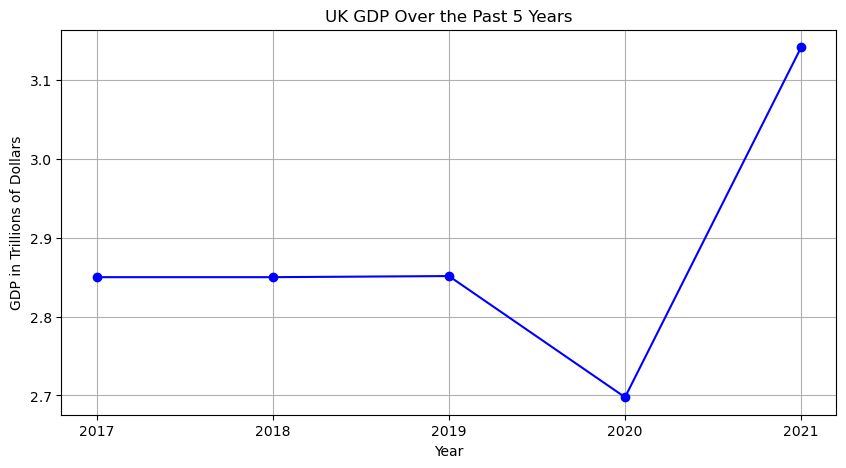

Agent result from invocation: content='' additional_kwargs={'tool_calls': [{'id': 'call_lprWGErRXg5g2NtwXhRZyajq', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Years for the X-axis\\nyears = [2017, 2018, 2019, 2020, 2021]\\n\\n# GDP values for the Y-axis (in trillions of dollars, based on the provided snippets and assuming placeholders for missing years)\\n# Note: The actual values for 2017 and 2018 are placeholders and should be replaced with accurate data.\\ngdp_values = [2.85, 2.85, 2.85141, 2.69781, 3.14151]  # Placeholder values for 2017 and 2018\\n\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\', linestyle=\'-\', color=\'b\')\\nplt.title(\'UK GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Trillions of Dollars\')\\nplt.grid(True)\\nplt.xticks(years)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 230, 'prompt_tokens': 1464, 'total

In [109]:
for s in events:
    print(s)
    print("----")